## Image segmentation with fastai

In [194]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os
from torchvision import transforms
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import numpy as np
from torchvision import utils
import torch
import pandas as pd

In [2]:
path = os.getcwd()
img_path = path+'/data/h5'
path_img = img_path+'/img_wmasks'
path_lbl = path+'/data/h5/masks2/'

## Data

In [3]:
fnames = get_image_files(path_img)
img_f = fnames[0]
lbl_names = get_image_files(path_lbl)
get_y_fn = lambda x: path_lbl+f'/{x.stem}_mask.tif'
mask = open_mask(get_y_fn(img_f))

src_size = np.array(mask.shape[1:])
codes = array(['Background' , 'Building'])
size = src_size//2


free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=16
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

using bs=16, have 10813MB of GPU RAM free


In [4]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

metrics=acc_camvid
wd=1e-2

learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

## Datasets

In [5]:
data.valid_dl = data.valid_dl.new(shuffle=True)

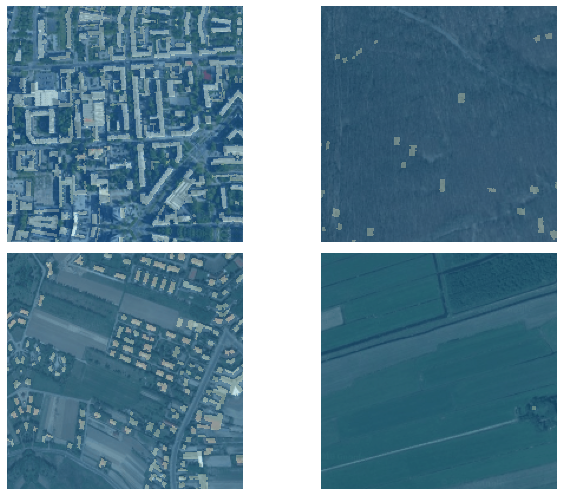

In [18]:
data.show_batch(2, figsize=(10,7))

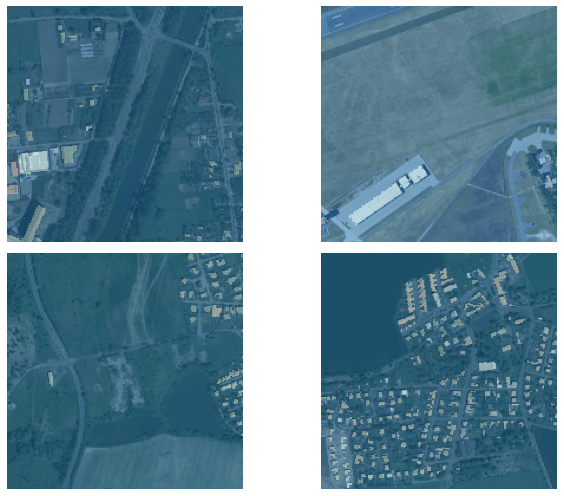

In [19]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


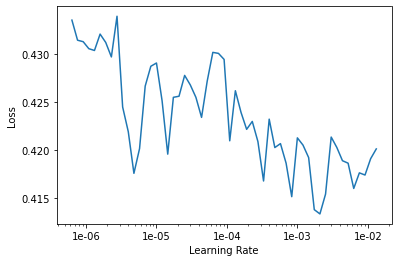

In [30]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=3e-3

In [32]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.265417,0.243372,0.324725,03:31
1,0.246922,0.250347,0.514362,03:17
2,0.232454,0.220808,0.490394,03:17
3,0.227873,0.216771,0.508521,03:17
4,0.229264,0.215252,0.536646,03:18
5,0.226656,0.218778,0.496708,03:18
6,0.232239,0.217728,0.561472,03:18
7,0.228866,0.212635,0.578099,03:18
8,0.213661,0.208962,0.576201,03:19
9,0.206083,0.197514,0.572087,03:18


In [33]:
learn.save('stage-1')

In [34]:
learn.load('stage-1');

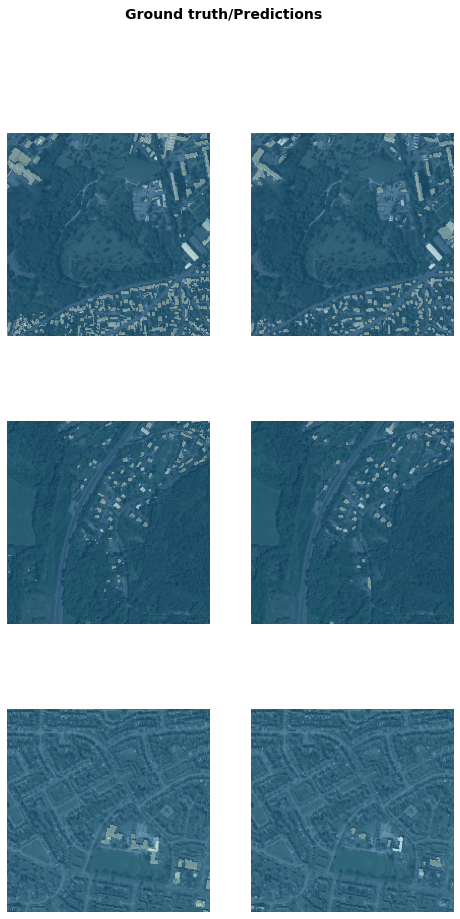

In [35]:
learn.show_results(rows=3, figsize=(8,15))

In [36]:
learn.unfreeze()

In [31]:
lrs = slice(lr/400,lr/4)

In [38]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.206849,0.196173,0.561892,03:37
1,0.195588,0.196012,0.578121,03:30
2,0.194290,0.194718,0.584786,03:30
3,0.203412,0.193067,0.568944,03:31
4,0.193004,0.192269,0.571688,03:31
5,0.202558,0.192248,0.574433,03:31
6,0.202170,0.192402,0.561554,03:31
7,0.186901,0.194372,0.536761,03:34
8,0.204457,0.191367,0.547763,03:31
9,0.196480,0.192179,0.604182,03:31


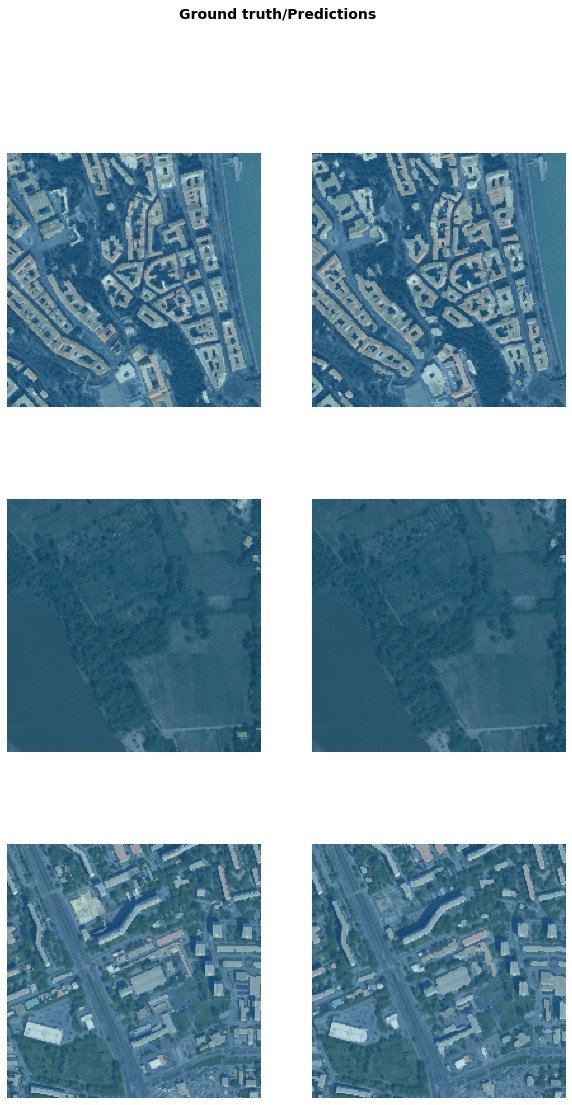

In [40]:
learn.show_results(rows=3, figsize=(10,18))

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [26]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=3
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=8, have 9990MB of GPU RAM free


In [27]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [28]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [46]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


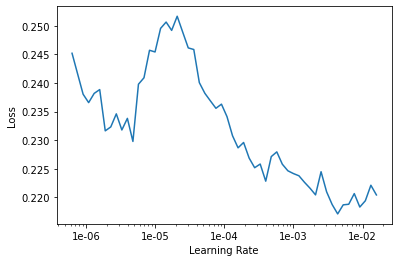

In [47]:
lr_find(learn)
learn.recorder.plot()

In [48]:
lr=1e-3

In [49]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.192988,0.194877,0.563373,11:03
1,0.206289,0.189780,0.586875,11:00
2,0.197930,0.188354,0.594897,11:00
3,0.183384,0.187282,0.636533,11:01
4,0.188211,0.185410,0.616907,11:01
5,0.196201,0.183721,0.607978,11:03
6,0.195956,0.181219,0.601281,11:01
7,0.180226,0.181549,0.616118,11:01
8,0.195746,0.179340,0.641098,11:00
9,0.180412,0.176606,0.623988,11:01


In [50]:
learn.save('stage-1-big')

In [47]:
learn.load('stage-1-big');

In [30]:
learn.unfreeze()

In [31]:
lrs = slice(1e-6,lr/10)

In [32]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.178157,0.177290,0.627877,23:40
1,0.194858,0.184552,0.541604,23:35
2,0.174221,0.235006,0.601460,23:36
3,0.208536,0.201562,0.565716,23:37
4,0.190903,0.184813,0.603753,23:36
5,0.180338,0.194739,0.575114,23:36
6,0.194246,0.205351,0.607111,23:37
7,0.173586,0.268123,0.581080,23:37
8,0.186383,0.388126,0.591671,23:37
9,0.195230,0.969050,0.591985,23:37


In [33]:
learn.save('stage-2-big')

In [29]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;

Train: LabelList (8829 items)
x: SegmentationItemList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: SegmentationLabelList
ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400)
Path: /projects/qg35/jlgao2/FYP-Sandbox/data/h5/img_wmasks;

Valid: LabelList (2207 items)
x: SegmentationItemList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: SegmentationLabelList
ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400)
Path: /projects/qg35/jlgao2/FYP-Sandbox/data/h5/img_wmasks;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

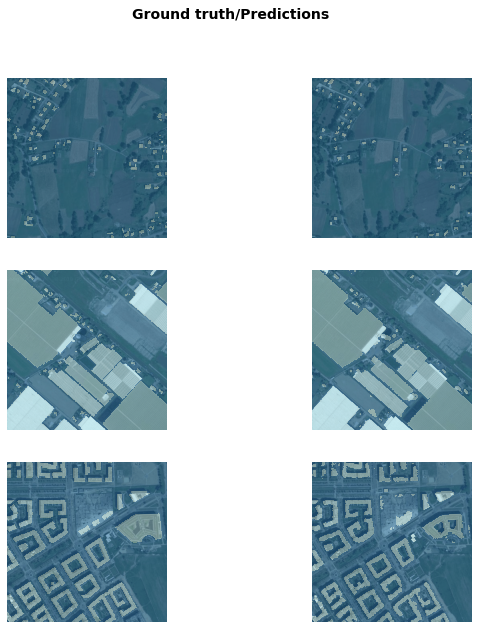

In [31]:
learn.show_results(rows=3, figsize=(10,10))

In [32]:
learn.export()

In [33]:
learn = load_learner(path_img)

## Inference

In [17]:
path_infer = img_path+'/s2-hr/'
path_infer_400 = img_path+'/s2-hr-400/'
path_infer_mask = img_path+'/s2-hr-mask/'
il = ImageList.from_folder(path_infer_400)
gt_il = ImageList.from_folder(path_img)

In [8]:
#runonce
onlypngs = []
onlypngs = [f for f in os.listdir(path_infer) if os.path.isfile(os.path.join(path_infer, f))]

for line in onlypngs:
    gt = Image.open(path_infer+line)
    gt = gt.resize((400, 400))
    gt.save(path_infer_400+line)

In [9]:
onlypngs

['9148000_5818800_result.png',
 '8591200_5544800_result.png',
 '9056400_5682000_result.png',
 '9294400_5559600_result.png',
 '8338400_5494000_result.png',
 '8289200_5493600_result.png',
 '9278800_5861600_result.png',
 '9280000_5872000_result.png',
 '8817600_5992400_result.png',
 '9368000_5532800_result.png',
 '9153200_5818800_result.png',
 '8337600_5494800_result.png',
 '9284000_5865200_result.png',
 '8332800_5494000_result.png',
 '9153600_5818000_result.png',
 '9270800_5675600_result.png',
 '9072400_5682000_result.png',
 '8589200_5539200_result.png',
 '8596800_5537600_result.png',
 '9152800_5823200_result.png',
 '8334000_5492400_result.png',
 '9068400_5681200_result.png',
 '9280800_5673600_result.png',
 '8339200_5491600_result.png',
 '9605200_6073200_result.png',
 '8494000_5766800_result.png',
 '9277200_5863200_result.png',
 '9370000_5517200_result.png',
 '8819200_5992800_result.png',
 '9060400_5682000_result.png',
 '8490000_5774000_result.png',
 '9063200_5688800_result.png',
 '849160

In [11]:
onlytifs = [f for f in os.listdir(path_infer) if os.path.isfile(os.path.join(path_infer, f))]
tifs = []
for idx, line in enumerate(onlytifs):
    tifs.append(line.replace('_result.png', '.tif'))
    
for idx, im in enumerate(il):
    msk = learn.predict(im)[0]
    msk.save(path_infer_mask+tifs[idx])

In [15]:
get_y_fn = lambda x: path_infer_mask+f'/{x.stem}.tif'
get_gtmask_fn = lambda x: path_lbl+f'/{x.stem}_mask.tif'
get_gtimg_fn = lambda x: path_img+f'/{x.stem}.png'

Text(0.5, 1.0, 'GT Mask')

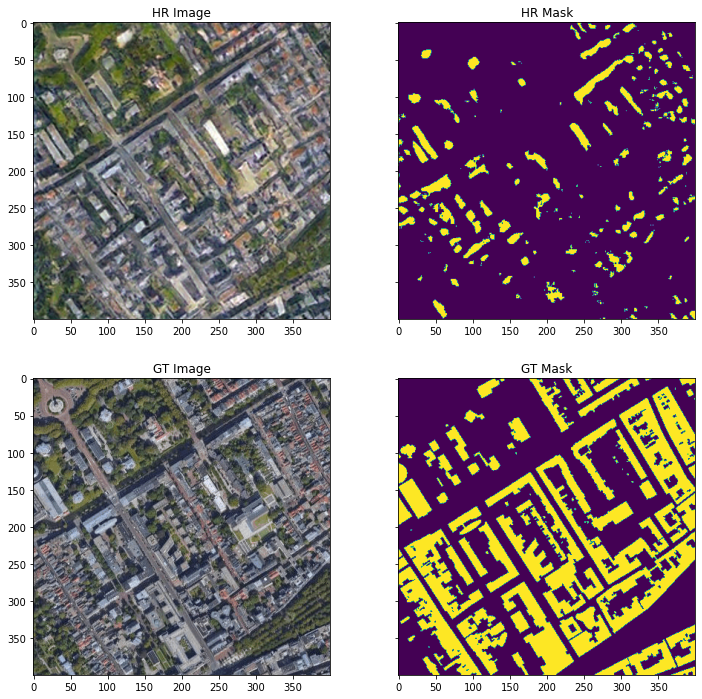

In [263]:
idx = 512

img = transforms.ToPILImage()(il[idx].data)
gt_img = Image.open(get_gtimg_fn(il.items[idx]))
oldmask = Image.open(get_gtmask_fn(il.items[idx]))
mask = Image.open(get_y_fn(il.items[idx]))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(12,12))
ax1.imshow(img)
ax1.set_title('HR Image')
ax2.imshow(mask)
ax2.set_title('HR Mask')
ax3.imshow(gt_img)
ax3.set_title('GT Image')
ax4.imshow(oldmask)
ax4.set_title('GT Mask')

Text(0.5, 1.0, 'Original 0.5')

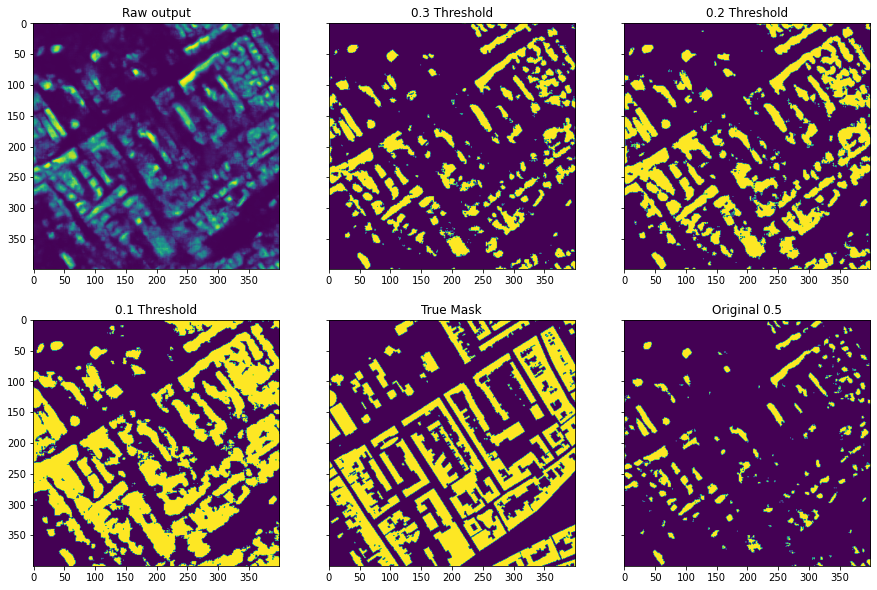

In [264]:
thresh = learn.predict(il[idx])[2][1]
thresh05 = thresh>0.3
thresh03 = thresh>0.2
thresh01 = thresh>0.1
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True, figsize=(15,10))
ax1.imshow(thresh.numpy())
ax1.set_title('Raw output')
ax2.imshow(thresh05.numpy())
ax2.set_title('0.3 Threshold')
ax3.imshow(thresh03.numpy())
ax3.set_title('0.2 Threshold')
ax4.imshow(thresh01.numpy())
ax4.set_title('0.1 Threshold')
ax5.imshow(oldmask)
ax5.set_title('True Mask')
ax6.imshow(mask)
ax6.set_title('Original 0.5')

In [227]:
get_roc_fn = lambda x, suffix: img_path+'/roc/'+f'{suffix}/{x.stem}.tif'
get_stem = lambda x: {x.stem}

In [225]:
#true positive rate
def tpr(pred, gt):
    num = torch.logical_and(pred, gt).sum().item()
    denom = gt.sum().item()
    return(num/denom)
    
def fpr(pred, gt):
    num = torch.logical_and(pred, ~gt).sum().item()
    denom = (~gt).sum().item()
    return(num/denom)

In [245]:
results = []

for idx, im in enumerate(il):
    pred = learn.predict(im)[2][1]
    gt_mask = (transforms.ToTensor()(Image.open(get_gtmask_fn(il.items[idx]))).squeeze()*255).bool()
    
    zero1 = (pred > 0.025).bool()
    zero2 = (pred > 0.01).bool()
    zero3 = (pred > 0.0175).bool()
#     zero4 = (pred > 0.4).bool()
#     zero5 = (pred > 0.5).bool()
#     zero6 = (pred > 0.6).bool()
    
    tpr1 = tpr(zero1, gt_mask)
    tpr2 = tpr(zero2, gt_mask)
    tpr3 = tpr(zero3, gt_mask)
#     tpr4 = tpr(zero4, gt_mask)
#     tpr5 = tpr(zero5, gt_mask)
#     tpr6 = tpr(zero6, gt_mask)
    
    fpr1 = fpr(zero1, gt_mask)
    fpr2 = fpr(zero2, gt_mask)
    fpr3 = fpr(zero3, gt_mask)
#     fpr4 = fpr(zero4, gt_mask)
#     fpr5 = fpr(zero5, gt_mask)
#     fpr6 = fpr(zero6, gt_mask)
    
    results.append((get_stem(il.items[idx]), tpr1, fpr1, tpr2, fpr2, tpr3, fpr3))
#     tpr4, fpr4, tpr5, fpr5, tpr6, fpr6

In [214]:
pred = (learn.predict(il[idx])[2][1]>0.1).bool()
gt = (transforms.ToTensor()(Image.open(get_gtmask_fn(il.items[idx]))).squeeze()*255).bool()

In [220]:
tpr(pred, gt)

0.57678449123016

In [221]:
fpr(pred, gt)

0.25948631139306594

In [217]:
torch.logical_and(gt, pred)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [223]:
pred.sum()

tensor(52173)

In [224]:
gt.sum()

tensor(33581)

In [246]:
results_df = pd.DataFrame(results, columns =['Loc ID', 'TP1', 'FP1', 'TP2', 'FP2', 'TP3', 'FP3']) 
#  'TP4', 'FP4', 'TP5', 'FP5', 'TP6', 'FP6'

In [247]:
results_df

,Loc ID,TP1,FP1,TP2,FP2,TP3,FP3
0,{9062000_5682800},0.902498,0.446291,0.972923,0.664609,0.938283,0.530539
1,{9370800_5526000},0.807470,0.434913,0.947977,0.701688,0.894175,0.549100
2,{9065200_5682800},0.805556,0.169046,0.924811,0.282007,0.856021,0.204475
3,{9059200_5690800},0.835957,0.039246,0.966031,0.097674,0.936205,0.053145
4,{9370000_5517600},0.909856,0.373122,0.966203,0.639453,0.936963,0.470521
...,...,...,...,...,...,...,...
1782,{8288400_5496400},0.798378,0.579161,0.951198,0.858652,0.872986,0.699119
1783,{8493200_5769200},0.950628,0.803759,0.991033,0.933477,0.971082,0.866028
1784,{8590400_5632800},0.639733,0.237685,0.902621,0.485648,0.749783,0.324230
1785,{9060400_5681600},0.860455,0.085135,0.964803,0.210001,0.903520,0.117327


In [248]:
results_df.mean(axis=0)

TP1    0.745814
FP1    0.350621
TP2    0.872114
FP2    0.534616
TP3    0.800861
FP3    0.417655
dtype: float64